# Churn model - Training a simple classification model
In this tutorial we will cover how to implement a simple Machine Learning model to predict Customer's Churn following these steps:

**Pre-Requisites**
* Register dataset "Clientes"

## Get the data
We will use a learning purposes dataset created with simulated data. This dataset can be found [here](https://raw.githubusercontent.com/lfbraz/azure-databricks-mlops/master/dataset/dados_clientes.csv). We will download this dataset to `dbfs` to be able to import data to dataframes.

In [ ]:
from azureml.core import Workspace, Dataset

workspace = Workspace.from_config()

dataset = Dataset.get_by_name(workspace, name='Clientes')
customer_data = dataset.to_pandas_dataframe()

We will develop a `sklearn` model so it will be easier to work with a Pandas Dataframe instead of a spark one (of course, when we are working in an spark environment it would be better to work with spark dataframes because of performance aspects, however for this tutorial we will use Pandas for learning reasons)

In [7]:
customer_data.head(5)

,CodigoCliente,Titulo,PrimeiroNome,UltimoNome,Idade,Sexo,Endereco,Cidade,UF,UFCompleto,...,AnosDeRelacionamentoBanco,JaUsouChequeEspecial,QtdEmprestimos,NumeroAtendimentos,TMA,IndiceSatisfacao,Saldo,CLTV,CanalPref,Churn
0,1.0,Sra.,Fernanda,Camargo,32.0,Feminino,"Rua Paulo Suplicy, 376",São Paulo,SP,São Paulo,...,3.0,0.0,1.0,7.0,2.0,4.0,55229.0,65.0,Push,0.0
1,2.0,Sr.,Paulo,Dias,63.0,Masculino,Estrada Transcastanhal 456,Castanhal,PA,Pará,...,2.0,1.0,0.0,15.0,87.0,3.0,9936.0,66.0,Email,1.0
2,3.0,Sr.,Enzo,Araujo,64.0,Masculino,Rua Joana D'Arc Gonçalves 576,Araxá,MG,Minas Gerais,...,19.0,0.0,0.0,1.0,5.0,4.0,769.0,30.0,SMS,1.0
3,4.0,Sr.,Martim,Souza,59.0,Masculino,Rua Paulo Suplicy 376,São Paulo,SP,São Paulo,...,9.0,1.0,0.0,2.0,2.0,4.0,1246.0,76.0,Email,1.0
4,5.0,Sr.,Gabriel,Barros,21.0,Masculino,Rua M 879,Valparaíso de Goiás,GO,Goiás,...,16.0,0.0,0.0,3.0,4.0,4.0,2732.0,90.0,Email,0.0


## Data Visualization

Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, **IndiceSatisfacao** (An index that measure how satisfied a customer is with the service).

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


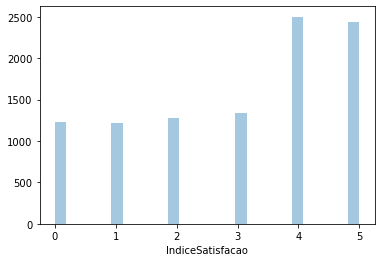

In [8]:
import seaborn as sns
sns.distplot(customer_data.IndiceSatisfacao, kde=False)

Now we can analyse how the numeric features correlate each other, `pandas` have a native method `corr()` that use `pearson` correlation by default (you can alter this behavior using the *method* parameter).

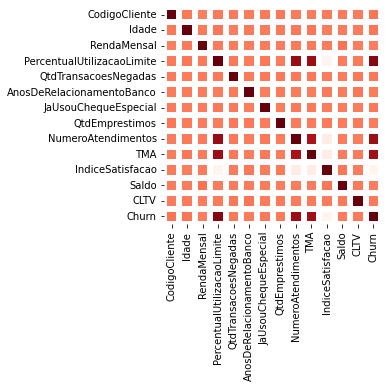

In [9]:
import matplotlib as plt

numeric_columns = []
for col in customer_data.columns:
  if(customer_data[col].dtypes!='object'):
    numeric_columns.append(col)
    
corr = customer_data[numeric_columns].corr()

ax1 = sns.heatmap(corr, cbar=0, linewidths=5, square=True, cmap='Reds')

## Preprocessing Data
Prior to training a model, check for missing values and split the data into training and validation sets.
In the last steps of this lab we already checked this point, so we cannot have any missing data

In [18]:
customer_data.isna().any()

CodigoCliente                 True
Titulo                        True
PrimeiroNome                  True
UltimoNome                    True
Idade                         True
Sexo                          True
Endereco                      True
Cidade                        True
UF                            True
UFCompleto                    True
CEP                           True
Pais                          True
PaisCompleto                  True
Email                         True
RendaMensal                   True
PercentualUtilizacaoLimite    True
QtdTransacoesNegadas          True
AnosDeRelacionamentoBanco     True
JaUsouChequeEspecial          True
QtdEmprestimos                True
NumeroAtendimentos            True
TMA                           True
IndiceSatisfacao              True
Saldo                         True
CLTV                          True
CanalPref                     True
Churn                         True
dtype: bool

In [21]:
customer_data = customer_data.dropna(axis=0)
customer_data.isna().any()

CodigoCliente                 False
Titulo                        False
PrimeiroNome                  False
UltimoNome                    False
Idade                         False
Sexo                          False
Endereco                      False
Cidade                        False
UF                            False
UFCompleto                    False
CEP                           False
Pais                          False
PaisCompleto                  False
Email                         False
RendaMensal                   False
PercentualUtilizacaoLimite    False
QtdTransacoesNegadas          False
AnosDeRelacionamentoBanco     False
JaUsouChequeEspecial          False
QtdEmprestimos                False
NumeroAtendimentos            False
TMA                           False
IndiceSatisfacao              False
Saldo                         False
CLTV                          False
CanalPref                     False
Churn                         False
dtype: bool

## Train the model

First of all let's split train and test data

In [22]:
from sklearn.model_selection import train_test_split
SEED = 2020

train, test = train_test_split(customer_data, random_state=SEED, test_size=0.33)

In [23]:
train.head(1)

,CodigoCliente,Titulo,PrimeiroNome,UltimoNome,Idade,Sexo,Endereco,Cidade,UF,UFCompleto,...,AnosDeRelacionamentoBanco,JaUsouChequeEspecial,QtdEmprestimos,NumeroAtendimentos,TMA,IndiceSatisfacao,Saldo,CLTV,CanalPref,Churn
3782,3773.0,Sr.,Ryan,Goncalves,37.0,Masculino,Rua Caetano Sampieri 554,Bauru,SP,São Paulo,...,18.0,1.0,3.0,49.0,95.0,0.0,9681.0,86.0,Email,1.0


In [24]:
TARGET_COLUMN = 'Churn'
drop_columns = [TARGET_COLUMN, 'CodigoCliente'] 

X_train = train[numeric_columns].drop(drop_columns, axis=1)
X_test = test[numeric_columns].drop(drop_columns, axis=1)

y_train = train[TARGET_COLUMN]
y_test = test[TARGET_COLUMN]

## Building a Baseline Model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn.

In [34]:
import xgboost as xgb

params = {'early_stopping_rounds': 50, 
              'learning_rate': 0.5, 
              'max_depth': 30, 
              'maximize': False, 
              'min_child_weight': 15.00, 
              'num_boost_round': 1000, 
              'reg_alpha': 0.50, 
              'reg_lambda': 0.20, 
              'objective': 'binary:hinge',
              'seed': 2021}

def train_model(X_train, y_train, X_test, y_test, params):
    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)

    model = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                       evals=[(test, "test")], early_stopping_rounds=50, verbose_eval=False)
    return model

model = train_model(X_train, y_train, X_test, y_test, params)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [43]:
test = xgb.DMatrix(data=X_test, label=y_test)

y_pred = model.predict(test)
y_pred

array([1., 0., 1., ..., 1., 0., 0.], dtype=float32)

#### Model Evaluation

Get False and True Positive rate

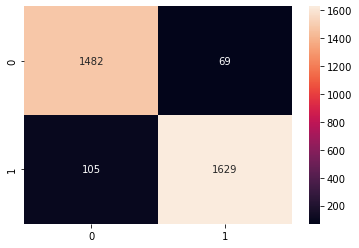

In [44]:
from sklearn.metrics import confusion_matrix
  
c_matrix_log = confusion_matrix(
  y_test, y_pred, labels=[0, 1])
sns.heatmap(
    c_matrix_log, annot=True, fmt="d")

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print('Results: ',
          str(model).split('(')[0], '\nPrecisão: {0:.3}'.format(
              precision_score(y_test, y_pred)), '\nRecall: {0:.3f}'.format(
                  recall_score(y_test, y_pred)), '\nAUC: {0:.3f}'.format(
                      roc_auc_score(y_test, y_pred)),
          '\nAcurácia: {0:.3f}'.format(accuracy_score(y_test, y_pred)), '\n')

Results:  <xgboost.core.Booster object at 0x7f392dfe59e8> 
Precisão: 0.959 
Recall: 0.939 
AUC: 0.947 
Acurácia: 0.947 



Seems to be a good model to begin. 😃

But let's try to make some improvements ...